2025-04-21 13:49:03.734758: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745243343.975160      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745243344.046731      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


SMOTE import failed. Proceeding without SMOTE.
Splitting audio files...
Error processing /kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original/jazz/jazz.00054.wav: 
Audio splitting completed.
Extracting features from split audio...


[I 2025-04-21 13:59:38,333] A new study created in memory with name: no-name-2480aa41-555a-467c-95d3-dd4fb3700ffd


Feature extraction completed.
Skipping SMOTE.
Running Optuna optimization...


2025-04-21 13:59:38.343474: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
[I 2025-04-21 14:03:18,513] Trial 0 finished with value: 0.8948027491569519 and parameters: {'conv_filters_1': 64, 'conv_filters_2': 128, 'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.4997816448817984, 'learning_rate': 0.0002941147390510452}. Best is trial 0 with value: 0.8948027491569519.
[I 2025-04-21 14:04:29,030] Trial 1 finished with value: 0.8666249513626099 and parameters: {'conv_filters_1': 32, 'conv_filters_2': 128, 'lstm_units': 64, 'dense_units': 128, 'dropout_rate': 0.33268673793703846, 'learning_rate': 0.0030697899011173607}. Best is trial 0 with value: 0.8948027491569519.
[I 2025-04-21 14:05:57,221] Trial 2 finished with value: 0.8096430897712708 and parameters: {'conv_filters_1': 32, 'conv_filters_2': 64, 'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.45892044093260864, '

Optuna optimization completed.
✅ Best Parameters: {'conv_filters_1': 64, 'conv_filters_2': 128, 'lstm_units': 128, 'dense_units': 128, 'dropout_rate': 0.4997816448817984, 'learning_rate': 0.0002941147390510452}
✅ Best Validation Accuracy: 0.8948027491569519
Training final model...
Epoch 1/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.3212 - loss: 1.8867 - val_accuracy: 0.5980 - val_loss: 1.1795 - learning_rate: 2.9411e-04
Epoch 2/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 41ms/step - accuracy: 0.5692 - loss: 1.2489 - val_accuracy: 0.6825 - val_loss: 0.9758 - learning_rate: 2.9411e-04
Epoch 3/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 40ms/step - accuracy: 0.6553 - loss: 1.0019 - val_accuracy: 0.7013 - val_loss: 0.8985 - learning_rate: 2.9411e-04
Epoch 4/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.7115 - loss: 0.8491 - val_accuracy: 0.7533 - val_loss: 0.7331 - learning_rate: 2.9411e-04
Epoch 5/50
200/200 ━━━━━━━━━━━━━━━━━━━━ 8s 39ms/step - accuracy: 0.7620 - loss: 0.6968 - 

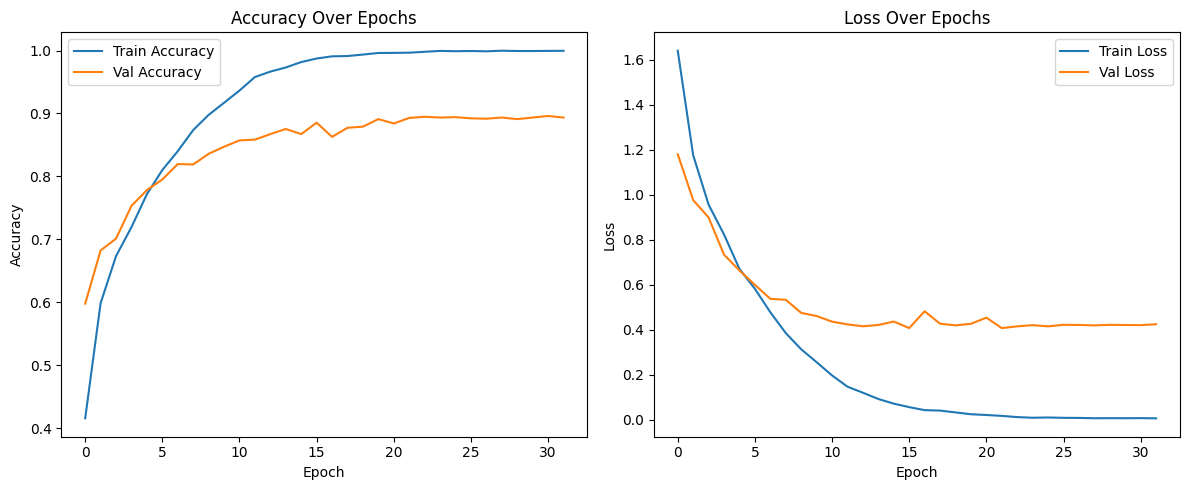

In [1]:
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
import os
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, accuracy_score
from keras.models import Model
from keras.layers import Input, Conv1D, MaxPooling1D, Reshape, Bidirectional, LSTM, Dense, Dropout, Attention, GlobalAveragePooling1D
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.utils import to_categorical
import optuna
import tensorflow as tf
import pickle
import warnings
warnings.filterwarnings("ignore")

# Optional SMOTE import
try:
    from imblearn.over_sampling import SMOTE
    use_smote = True
except ImportError:
    print("SMOTE import failed. Proceeding without SMOTE.")
    use_smote = False

# Force CPU usage to avoid CUDA warnings
os.environ["CUDA_VISIBLE_DEVICES"] = ""

# ---------------------------------------------------------------------------
# 📦 Dataset Paths for Kaggle
# ---------------------------------------------------------------------------
audio_folder = "/kaggle/input/gtzan-dataset-music-genre-classification/Data/genres_original"
split_audio_folder = "/kaggle/working/split_wavs"  # Output directory for split audio

# ---------------------------------------------------------------------------
# ✂️ Split Audio Files into 3-Second Chunks
# ---------------------------------------------------------------------------
def split_audio_files(input_folder, output_folder, chunk_duration=3.0):
    os.makedirs(output_folder, exist_ok=True)
    for root, _, files in os.walk(input_folder):
        genre = os.path.basename(root)
        if genre == "genres_original":  # Skip parent directory
            continue
        genre_output_folder = os.path.join(output_folder, genre)
        os.makedirs(genre_output_folder, exist_ok=True)
        
        for filename in files:
            if filename.endswith('.wav'):
                file_path = os.path.join(root, filename)
                try:
                    y, sr = librosa.load(file_path, sr=None)
                    total_duration = librosa.get_duration(y=y, sr=sr)
                    num_chunks = int(total_duration // chunk_duration)
                    
                    for i in range(num_chunks):
                        start_sample = int(i * chunk_duration * sr)
                        end_sample = int((i + 1) * chunk_duration * sr)
                        chunk = y[start_sample:end_sample]
                        out_name = f"{filename[:-4]}_chunk{i}.wav"
                        out_path = os.path.join(genre_output_folder, out_name)
                        sf.write(out_path, chunk, sr)
                except Exception as e:
                    print(f"Error processing {file_path}: {e}")

print("Splitting audio files...")
split_audio_files(audio_folder, split_audio_folder)
print("Audio splitting completed.")

# ---------------------------------------------------------------------------
# 📌 Enhanced Feature Extraction Function
# ---------------------------------------------------------------------------
def extract_features(filepath, sr=22050, augment=False):
    try:
        y, sr = librosa.load(filepath, sr=sr, duration=3.0)
        
        # Data augmentation: time stretching
        if augment and np.random.random() > 0.5:
            stretch_rate = np.random.uniform(0.9, 1.1)
            y = librosa.effects.time_stretch(y, rate=stretch_rate)
        
        # Extract features
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=40)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        
        # Aggregate features
        features = np.hstack([
            np.mean(mfcc, axis=1),
            np.std(mfcc, axis=1),
            np.mean(chroma, axis=1),
            np.mean(mel, axis=1),
            np.mean(contrast, axis=1)
        ])
        return features
    except Exception as e:
        print(f"Feature extraction error for {filepath}: {e}")
        return None

# ---------------------------------------------------------------------------
# 📥 Load and Process Split Audio Data
# ---------------------------------------------------------------------------
X, y = [], []
genres = os.listdir(split_audio_folder)
print("Extracting features from split audio...")
for genre in genres:
    genre_folder = os.path.join(split_audio_folder, genre)
    if os.path.isdir(genre_folder):
        for file in os.listdir(genre_folder):
            if file.endswith('.wav'):
                filepath = os.path.join(genre_folder, file)
                features = extract_features(filepath, augment=True)
                if features is not None:
                    X.append(features)
                    y.append(genre)
print("Feature extraction completed.")

X = np.array(X)
y = np.array(y)

# Standardize features
scaler = StandardScaler()
X = scaler.fit_transform(X)

# Encode labels
label_encoder = LabelEncoder()
y_integer = label_encoder.fit_transform(y)
y_encoded = to_categorical(y_integer)

# Save scaler and label encoder
with open('/kaggle/working/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
with open('/kaggle/working/label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

# Handle class imbalance with SMOTE (if available)
if use_smote:
    print("Applying SMOTE...")
    smote = SMOTE(random_state=42)
    X_resampled, y_resampled = smote.fit_resample(X, y_encoded)
else:
    print("Skipping SMOTE.")
    X_resampled, y_resampled = X, y_encoded

# Expand dimensions for CNN input
X_resampled = np.expand_dims(X_resampled, -1)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# ---------------------------------------------------------------------------
# 📌 Model Definition with Optuna
# ---------------------------------------------------------------------------
def objective(trial):
    conv_filters_1 = trial.suggest_categorical('conv_filters_1', [32, 64])
    conv_filters_2 = trial.suggest_categorical('conv_filters_2', [64, 128])
    lstm_units = trial.suggest_categorical('lstm_units', [64, 128])
    dense_units = trial.suggest_categorical('dense_units', [64, 128])
    dropout_rate = trial.suggest_float('dropout_rate', 0.3, 0.5)
    learning_rate = trial.suggest_float('learning_rate', 1e-4, 1e-2, log=True)
    
    input_layer = Input(shape=(X_train.shape[1], 1))
    conv1 = Conv1D(filters=conv_filters_1, kernel_size=5, activation='relu', padding='same')(input_layer)
    pool1 = MaxPooling1D(pool_size=2)(conv1)
    conv2 = Conv1D(filters=conv_filters_2, kernel_size=5, activation='relu', padding='same')(pool1)
    pool2 = MaxPooling1D(pool_size=2)(conv2)
    reshape = Reshape((1, -1))(pool2)
    lstm = Bidirectional(LSTM(lstm_units, return_sequences=True))(reshape)
    attention = Attention()([lstm, lstm])
    context_vector = GlobalAveragePooling1D()(attention)
    dense = Dense(dense_units, activation='relu')(context_vector)
    dropout = Dropout(dropout_rate)(dense)
    output = Dense(y_train.shape[1], activation='softmax')(dropout)
    
    model = Model(inputs=input_layer, outputs=output)
    model.compile(loss='categorical_crossentropy',
                  optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
                  metrics=['accuracy'])
    
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
    
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=30,
                        batch_size=32, callbacks=[early_stop, reduce_lr], verbose=0)
    
    return max(history.history['val_accuracy'])

# Run Optuna optimization
print("Running Optuna optimization...")
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print("Optuna optimization completed.")

print("✅ Best Parameters:", study.best_params)
print("✅ Best Validation Accuracy:", study.best_value)

# ---------------------------------------------------------------------------
# 📊 Retrain Best Model
# ---------------------------------------------------------------------------
best_params = study.best_params

input_layer = Input(shape=(X_train.shape[1], 1))
conv1 = Conv1D(filters=best_params['conv_filters_1'], kernel_size=5, activation='relu', padding='same')(input_layer)
pool1 = MaxPooling1D(pool_size=2)(conv1)
conv2 = Conv1D(filters=best_params['conv_filters_2'], kernel_size=5, activation='relu', padding='same')(pool1)
pool2 = MaxPooling1D(pool_size=2)(conv2)
reshape = Reshape((1, -1))(pool2)
lstm = Bidirectional(LSTM(best_params['lstm_units'], return_sequences=True))(reshape)
attention = Attention()([lstm, lstm])
context_vector = GlobalAveragePooling1D()(attention)
dense = Dense(best_params['dense_units'], activation='relu')(context_vector)
dropout = Dropout(best_params['dropout_rate'])(dense)
output = Dense(y_train.shape[1], activation='softmax')(dropout)

final_model = Model(inputs=input_layer, outputs=output)
final_model.compile(loss='categorical_crossentropy',
                    optimizer=tf.keras.optimizers.Adam(learning_rate=best_params['learning_rate']),
                    metrics=['accuracy'])

# Train with early stopping
print("Training final model...")
history = final_model.fit(X_train, y_train, validation_split=0.2, epochs=50,
                          batch_size=32, callbacks=[
                              EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
                              ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5)
                          ], verbose=1)
print("Final model training completed.")

# ---------------------------------------------------------------------------
# 📊 Plot Accuracy and Loss
# ---------------------------------------------------------------------------
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.savefig('/kaggle/working/training_plots.png')

# ---------------------------------------------------------------------------
# 📊 Classification Report
# ---------------------------------------------------------------------------
y_pred_probs = final_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

print("\n✅ Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

# Save the model
final_model.save('/kaggle/working/genre_classification_model.h5')

print("✅ Training and saving completed. Model, scaler, and label encoder saved in /kaggle/working/.")